In [74]:
import math
import numpy as np
from scipy import interpolate
import cv2
import random
from matplotlib import pyplot as plt
%matplotlib inline

In [130]:
sigma = 5.0
sigmaSq = sigma*sigma
mutations = 32*256*256
checkpoints = 1000
print('sigma: ' + repr(sigma))
print('mutations: ' + repr(mutations))

sigma: 5.0
mutations: 2097152


In [109]:
img_1 = cv2.imread('lena.jpg',0)
img_2 = cv2.imread('radial_gradient.png',0)

img_2 = img_2+3.0

print('img 1: ' + repr(img_1))
print('img 2: ' + repr(img_2))
print('img 1 type: ' + repr(type(img_1))+' img 2 type: ' + repr(type(img_2)))
print('img 1 size: ' + repr(img_1.shape)+' img 2 size: ' + repr(img_2.shape))
print('img 1 max value: ' + repr(img_1.max())+' img 2 max value: ' + repr(img_2.max()))
print('img 1 min value: ' + repr(img_1.min())+' img 2 min value: ' + repr(img_2.min()))

img 1: array([[137, 135, 133, ..., 145, 147, 114],
       [137, 137, 133, ..., 144, 148, 114],
       [138, 133, 134, ..., 133, 125,  87],
       ...,
       [ 28,  29,  28, ...,  53,  61,  59],
       [ 20,  24,  25, ...,  64,  70,  65],
       [ 22,  30,  25, ...,  71,  67,  72]], dtype=uint8)
img 2: array([[3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]])
img 1 type: <class 'numpy.ndarray'> img 2 type: <class 'numpy.ndarray'>
img 1 size: (256, 256) img 2 size: (256, 256)
img 1 max value: 238 img 2 max value: 257.0
img 1 min value: 3 img 2 min value: 3.0


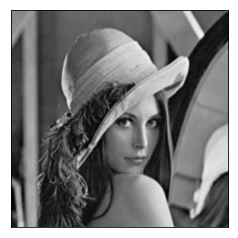

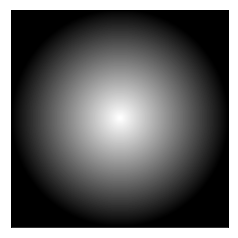

In [110]:
plt.imshow(img_1, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

plt.imshow(img_2, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


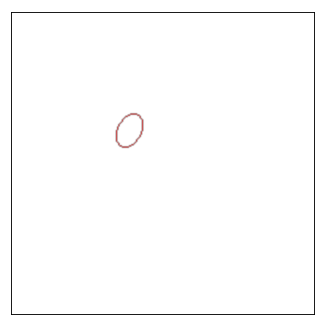

In [111]:
fig, ax = plt.subplots(figsize=(5, 5), dpi= 80, facecolor='w', edgecolor='k')
height, width = img_1.shape[:2]
ymin, ymax, xmin, xmax = 0, height-1, 0, width-1
extent = ymin, ymax, xmin, xmax

img = np.zeros((height, width, 4))
img[:,:,3] = 1.0-img_1
cv2.ellipse(img, (100,100),(10,15),30,0,360, [1,0,0,1], 1)
ax.imshow(img, interpolation = 'bicubic', extent=extent)
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()


In [134]:
class ImgDensity(object):
    def __init__(self, img):
        self.img = img.T
        self.height, self.width = img.shape[:2]
        self.dx = 1.0
        self.dy = 1.0
        self.alpha = 1.0
        self.eps = 0.000000001
        self.x = np.arange(self.width)
        self.y = np.arange(self.height)
        self.xx, self.yy = np.meshgrid(self.x, self.y)
        self.z = self.img[self.xx, self.yy]
        self.f = interpolate.interp2d(self.x, self.y, self.z, kind='linear')
        
    def getDensity(self,xp,yp):
        return self.f(xp,yp)
    
    def getLogDensity(self,xp,yp):
        return math.log(self.getDensity(xp,yp))
    
    def getGradLogDensity(self,xp,yp):
        #return np.gradient(self.getLogDensity(xp,yp))
        return 0.5*np.array([(self.getLogDensity(xp+self.dx,yp)-self.getLogDensity(xp-self.dx,yp))/self.dx,
                             (self.getLogDensity(xp,yp+self.dy)-self.getLogDensity(xp,yp-self.dy))/self.dy])
    
    def getHessLogDensity(self,xp,yp):
        #return hessian(self.getLogDensity(xp,yp))
        return 0.5*np.array([[(self.getGradLogDensity(xp+self.dx,yp)[0]-self.getGradLogDensity(xp-self.dx,yp)[0])/self.dx,
                             (self.getGradLogDensity(xp,yp+self.dy)[0]-self.getGradLogDensity(xp,yp-self.dy)[0])/self.dy],
                            [(self.getGradLogDensity(xp+self.dx,yp)[1]-self.getGradLogDensity(xp-self.dx,yp)[1])/self.dy,
                             (self.getGradLogDensity(xp,yp+self.dy)[1]-self.getGradLogDensity(xp,yp-self.dy)[1])/self.dx]])
    
    
    def getPreLogDensity(self,xp,yp):
        eigenValues, eigenVector = np.linalg.eig(self.getHessLogDensity(xp,yp))
        eigenBuff = eigenValues;
        for i in range(2):
            eigenBuff[i] = math.tanh(self.alpha*eigenValues[i])/eigenValues[i] if abs(eigenValues[i]) > self.eps else self.alpha
        return np.matmul(np.matmul(eigenVector, np.diag(eigenBuff)), eigenVector.T)

    
    def logProposalDensity(self, x0, x1, y0, y1):
        gradient    = self.getGradLogDensity(x0, x1)
        preCond = self.getPreLogDensity(x0, x1)
        
        return -np.linalg.norm(np.array([y0,y1])-np.array([x0,x1])-0.5*sigmaSq * np.matmul(preCond,gradient.T), ord=2)**2 / (2 * sigmaSq)
        

In [113]:
class MultivariateNormal(object):
    def __init__(self, mean, cov):
        self.mean = mean
        self.cov = cov
        self.eigenValue, self.eigenVector = np.linalg.eig(self.cov)
        self.scale = np.multiply(np.abs(self.eigenValue), np.array([np.linalg.norm(self.eigenVector[0,:], ord=2), 
                                                           np.linalg.norm(self.eigenVector[0,:], ord=2)]))
        self.angle = math.degrees(math.atan2(-self.eigenVector[0,1], self.eigenVector[0,0]))
        self.dim = mean.size
        
    def getSample(self, width, height):
        y0, y1 = np.random.multivariate_normal(self.mean, self.cov)
        if (y0 < 0):
            y0 = 0
        if (y0 > width-1):
            y0 = width-1
        if (y1 < 0):
            y1 = 0
        if (y1 > height-1):
            y1 = height-1
        return y0, y1 
    

5.472270673671475
1.7728893052366312
1.3907388348285137


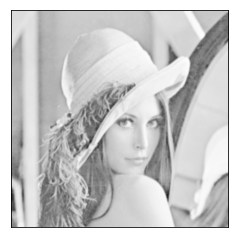

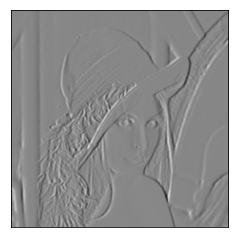

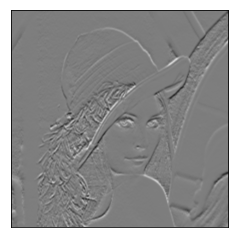

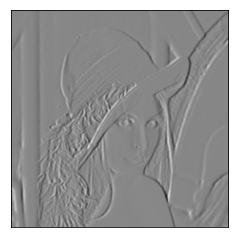

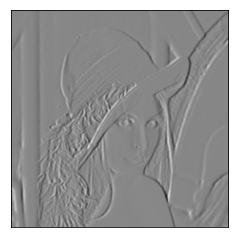

In [114]:
imgDens = ImgDensity(img_1)
k=1
dim = 255
kdim = k*dim
x = range(0,kdim)
y = range(0,kdim)
z = np.zeros((kdim,kdim))
zGrad = np.zeros((kdim,kdim,2))
zHess= np.zeros((kdim,kdim,2,2))
zPre= np.zeros((kdim,kdim,2,2))
for i in x:
    for j in y:
        z[i,j] = imgDens.getLogDensity(i/k, j/k)
        zGrad[i,j,:] = imgDens.getGradLogDensity(i/k, j/k)
        zHess[i,j,:,:] = imgDens.getGradLogDensity(i/k, j/k)
        zPre[i,j,:,:] = imgDens.getGradLogDensity(i/k, j/k)
        
print(z[:,:].max())
print(zGrad[:,:,0].max())
print(zGrad[:,:,1].max())

plt.imshow(z[:,:].T, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

plt.imshow(zGrad[:,:,0].T, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

plt.imshow(zGrad[:,:,1].T, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

plt.imshow(zHess[:,:,0,0].T, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

plt.imshow(zPre[:,:,0,0].T, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()


In [132]:
def draw_ellipse(
        img, center, axes, angle,
        startAngle, endAngle, color,
        thickness=1, lineType=cv2.LINE_AA, shift=10):
    center = (
        int(round(center[0] * 2**shift)),
        int(round(center[1] * 2**shift))
    )
    axes = (
        int(round(axes[0] * 2**shift)),
        int(round(axes[1] * 2**shift))
    )
    startAngle = int(round(startAngle* 2**shift))
    cv2.ellipse(
        img, center, axes, angle,
        startAngle, endAngle, color,
        thickness, lineType, shift)
    
def makeHistogram(img):
    
    imgDens = ImgDensity(img)
    histogram = np.zeros((imgDens.height, imgDens.width))
    
    x0 = random.randint(0,imgDens.width-1)
    x1 = random.randint(0,imgDens.height-1)
    Fx = imgDens.getLogDensity(x0, x1)
    
    #mean = np.array([x0,x1])
    #cov = sigmaSq*np.identity(2)
    mean = np.array([x0, x1])+0.5*sigmaSq*np.matmul(imgDens.getPreLogDensity(x0, x1),imgDens.getGradLogDensity(x0, x1))
    cov = sigmaSq*imgDens.getPreLogDensity(x0, x1)
    gaussian = MultivariateNormal(mean, cov)
    
    
    A = 0;
    for i in range(mutations):

        y0, y1 = gaussian.getSample(imgDens.width, imgDens.height)
        
        Fy = imgDens.getLogDensity(y0, y1)
        kxy = imgDens.logProposalDensity(x0, x1, y0, y1 )
        kyx = imgDens.logProposalDensity(y0, y1, x0, x1 )
        
        #Axy = min(1, math.exp((Fy) - (Fx )))
        Axy = min(1, math.exp((Fy + kxy) - (Fx + kyx)))
        if (random.uniform(0,1) < Axy):
            A = A + 1
            x0 = y0
            x1 = y1
            Fx=Fy
            #mean = np.array([x0,x1])
            #cov = sigmaSq*np.identity(2)
            mean = np.array([x0,x1]) + 0.5*sigmaSq*np.matmul(imgDens.getPreLogDensity(x0, x1),imgDens.getGradLogDensity(x0, x1))
            cov = sigmaSq*imgDens.getPreLogDensity(x0, x1)
            gaussian = MultivariateNormal(mean, cov)
            
        histogram[int(round(x0)),int(round(x1))] = histogram[int(round(x0)),int(round(x1))] + 1.0
        #histogram[int(round(x0)),int(round(x1))] = 1.0
        if (i%checkpoints) == 0:
            ARate = float(A)/float(i+1)
            print('i: ' + repr(i))
            print('acceptance rate: ' + repr(ARate))
            
            f = plt.figure(figsize=(15,15))
            ax = f.add_subplot(121)
            ax2 = f.add_subplot(122)
            
            img_temp = np.zeros((imgDens.height, imgDens.width,4))
            img_temp[:,:,3] = 1.0-histogram.T/histogram.max()
            draw_ellipse(img_temp, tuple(gaussian.mean), tuple(gaussian.scale), int(gaussian.angle), 0,360, [1,0,0,1])
            draw_ellipse(img_temp, tuple(gaussian.mean), tuple(2.0*gaussian.scale), int(gaussian.angle), 0,360, [0,1,0,1])
            cv2.circle(img_temp, (int(round(x0)),int(round(x1))), 1, [0,0,1,1],-1)
            ax.imshow(img_temp, interpolation = 'bicubic')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
            
            img_temp = np.zeros((imgDens.width, imgDens.height,4))
            img_temp[:,:,3] = 1.0-img/img.max()
            draw_ellipse(img_temp, tuple(gaussian.mean), tuple(gaussian.scale), int(gaussian.angle), 0,360, [1,0,0,1])
            draw_ellipse(img_temp, tuple(gaussian.mean), tuple(2.0*gaussian.scale), int(gaussian.angle), 0,360, [0,1,0,1])
            cv2.circle(img_temp, (int(round(x0)),int(round(x1))), 1, [0,0,1,1],-1)
            ax2.imshow(img_temp, interpolation = 'bicubic')
            plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
            
            plt.show()
    
    ARate = float(A)/float(mutations)
    
    print('acceptance rate: ' + repr(ARate))
    print('histogram max value: ' + repr(histogram.max()))
    histogram =  255 * histogram / histogram.max()
    
    cv2.imwrite("MetropolisTest_Final.png" ,histogram)


i: 0
acceptance rate: 1.0


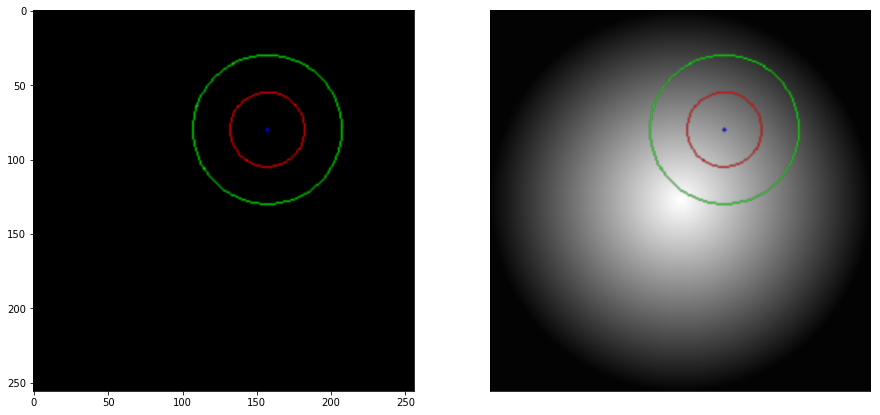

i: 1000
acceptance rate: 0.9410589410589411


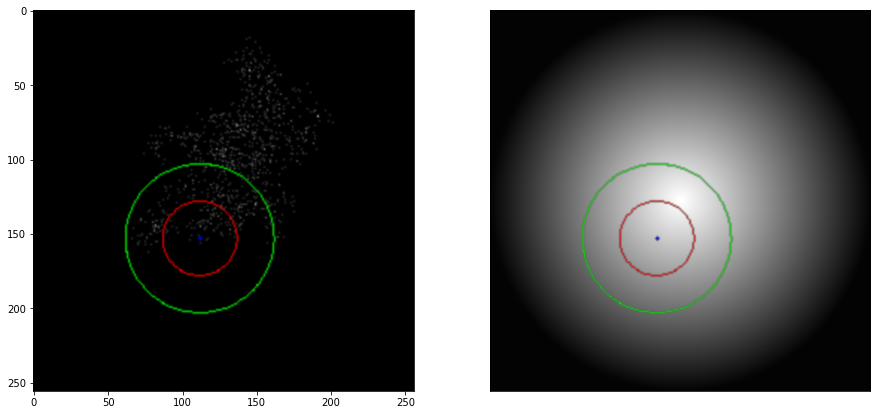

i: 2000
acceptance rate: 0.9505247376311844


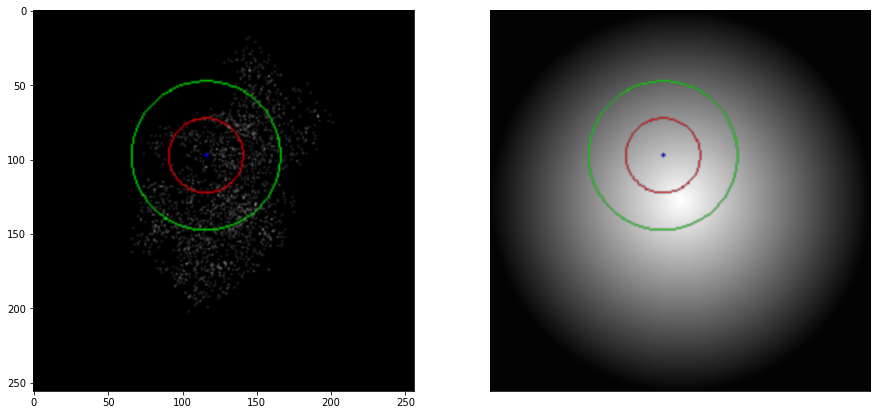

i: 3000
acceptance rate: 0.9510163278907031


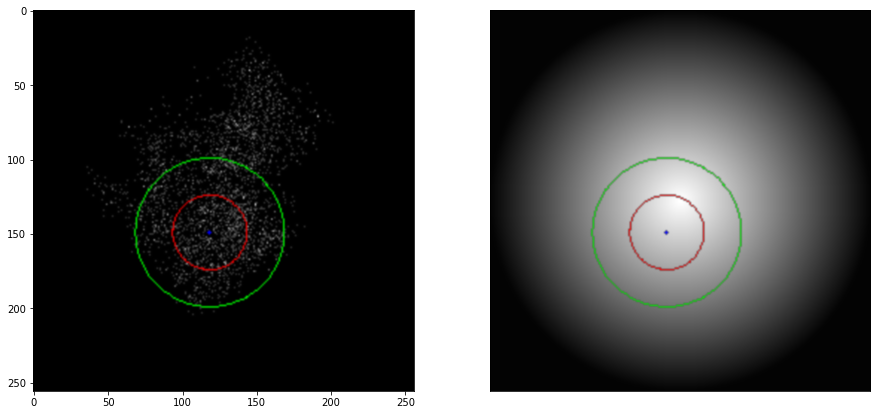

i: 4000
acceptance rate: 0.9517620594851287


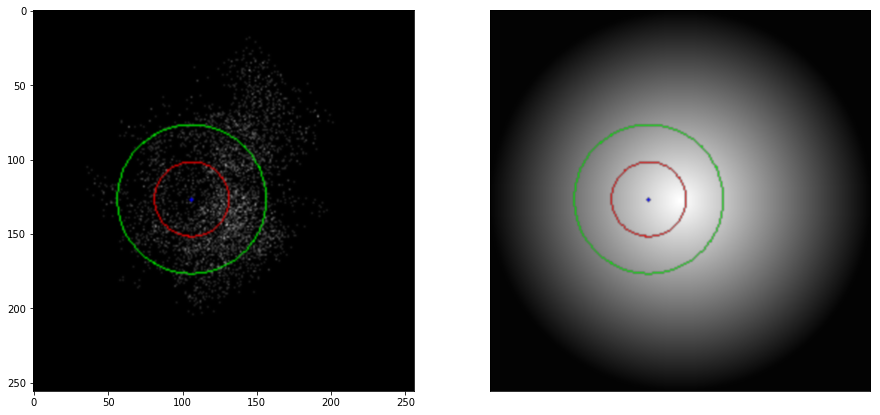

i: 5000
acceptance rate: 0.9500099980003999


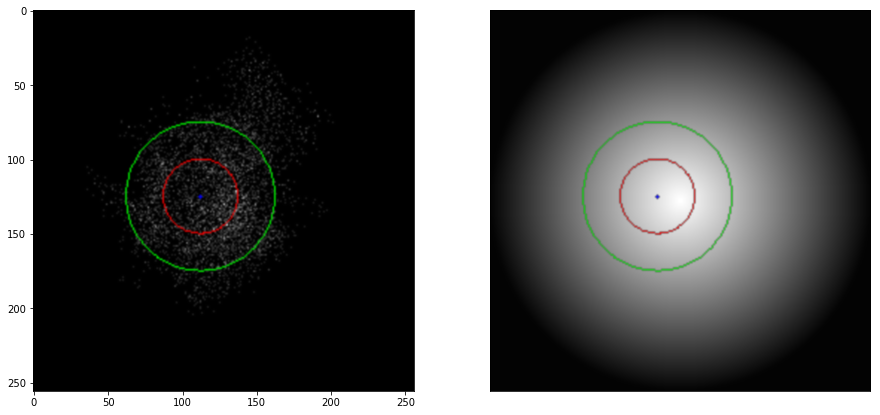

i: 6000
acceptance rate: 0.9515080819863356


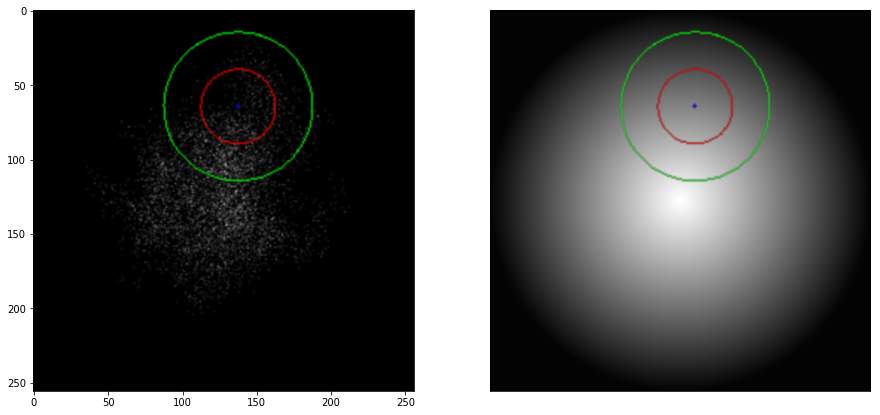

i: 7000
acceptance rate: 0.9510069990001428


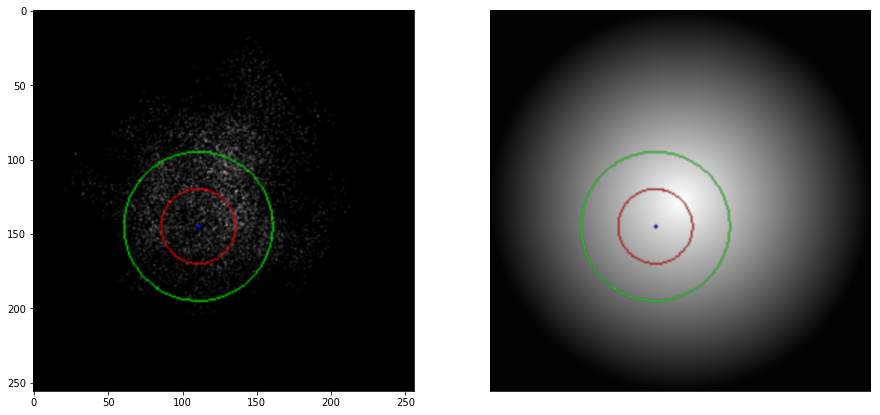

i: 8000
acceptance rate: 0.9511311086114236


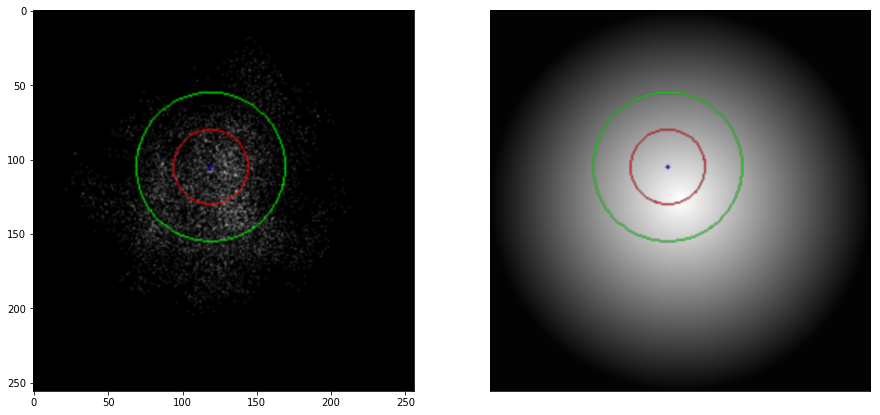

i: 9000
acceptance rate: 0.9510054438395734


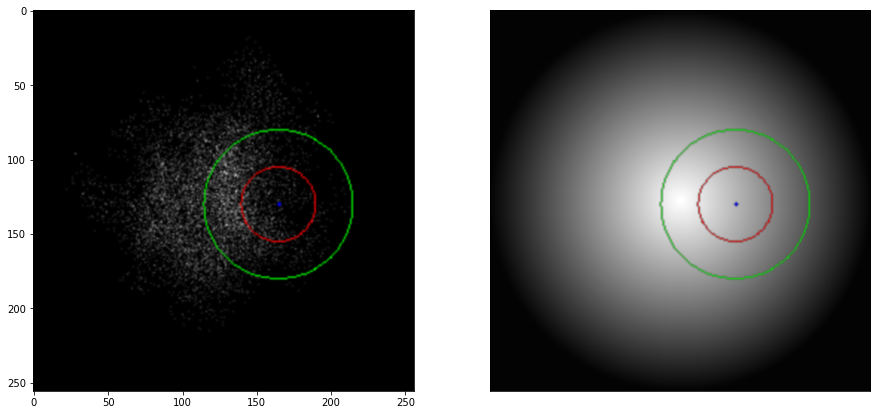

i: 10000
acceptance rate: 0.9503049695030497


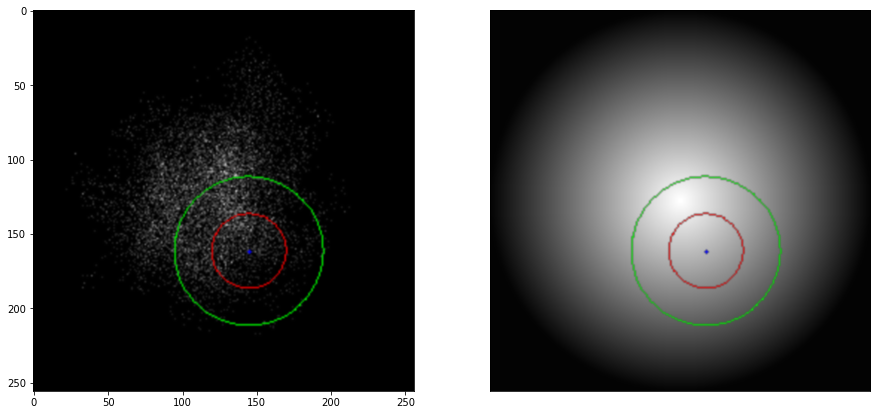

i: 11000
acceptance rate: 0.9493682392509771


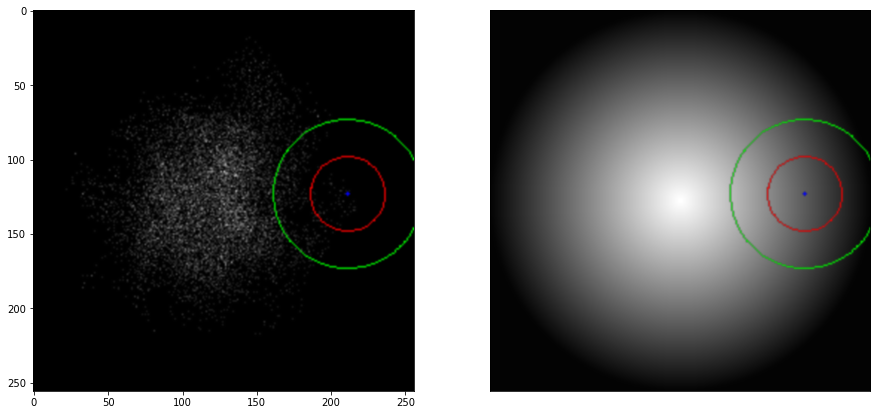

i: 12000
acceptance rate: 0.9490042496458628


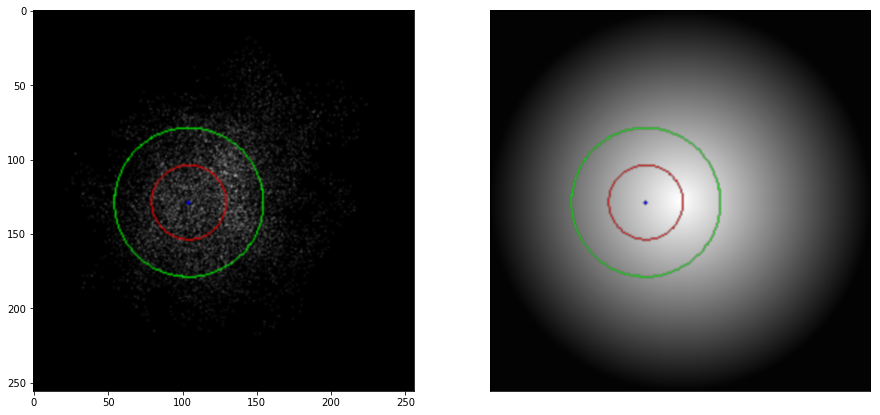

i: 13000
acceptance rate: 0.9499269286977925


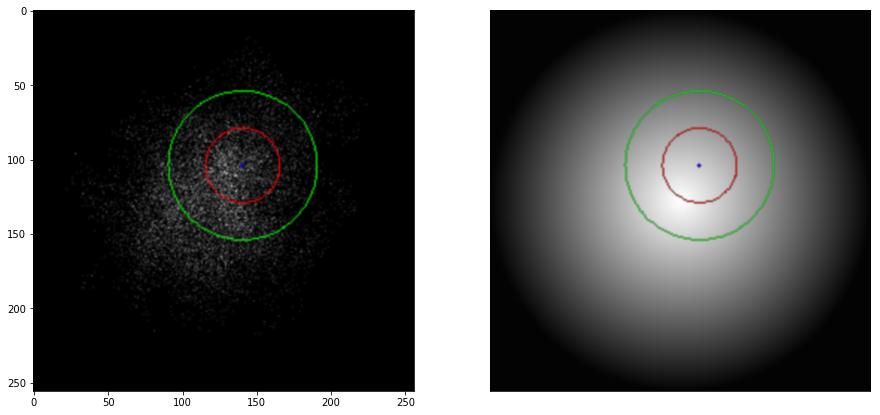

i: 14000
acceptance rate: 0.949717877294479


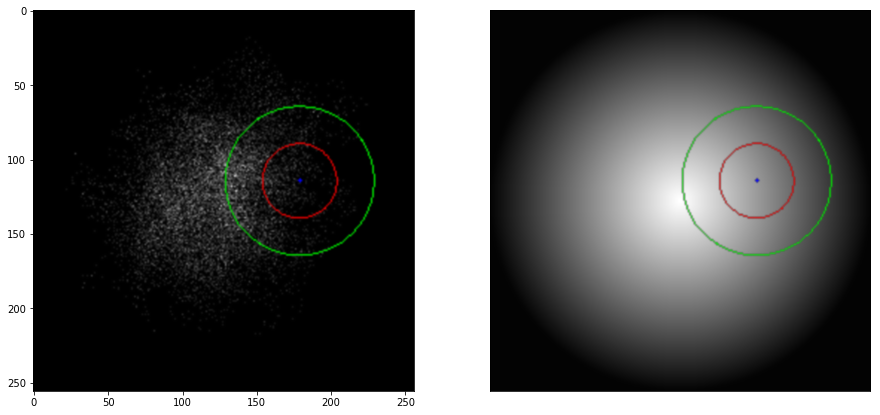

i: 15000
acceptance rate: 0.9495366975534965


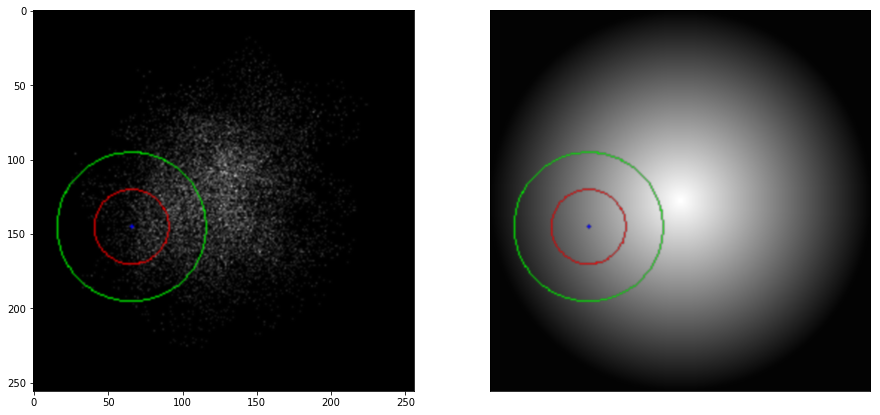

i: 16000
acceptance rate: 0.9494406599587526


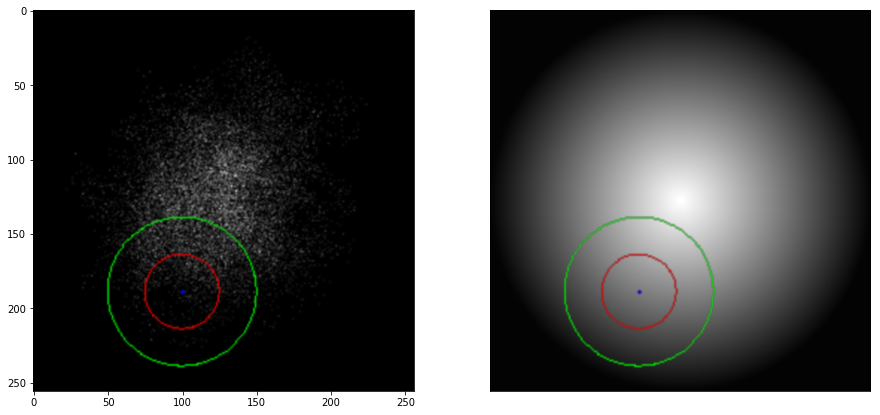

i: 17000
acceptance rate: 0.9490618198929475


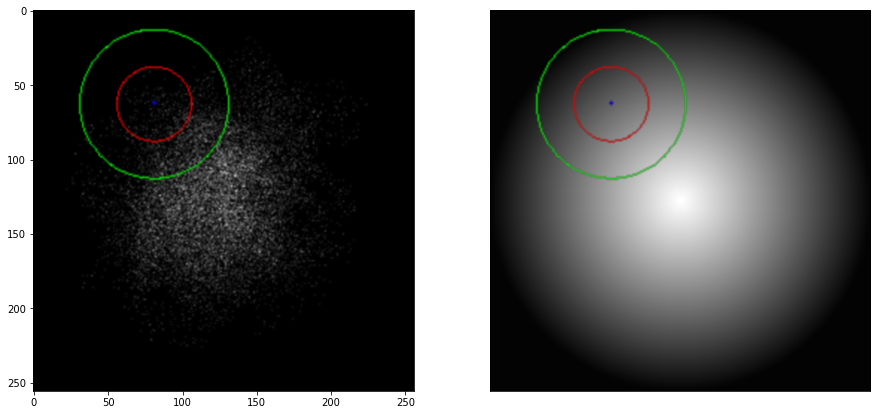

i: 18000
acceptance rate: 0.9493917004610855


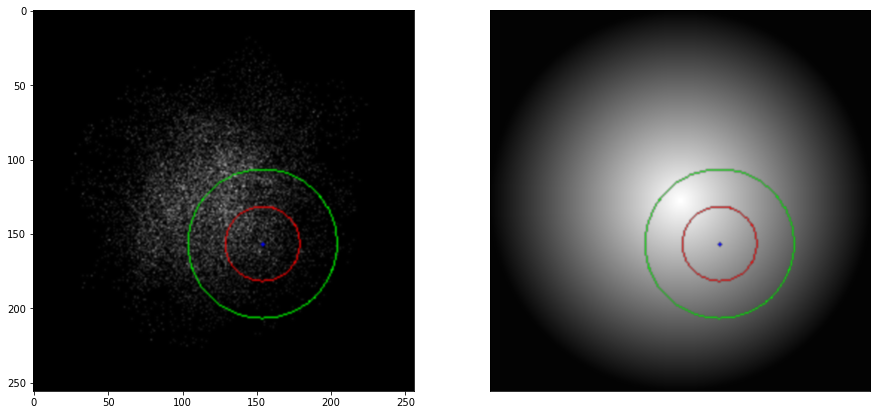

i: 19000
acceptance rate: 0.9493184569233198


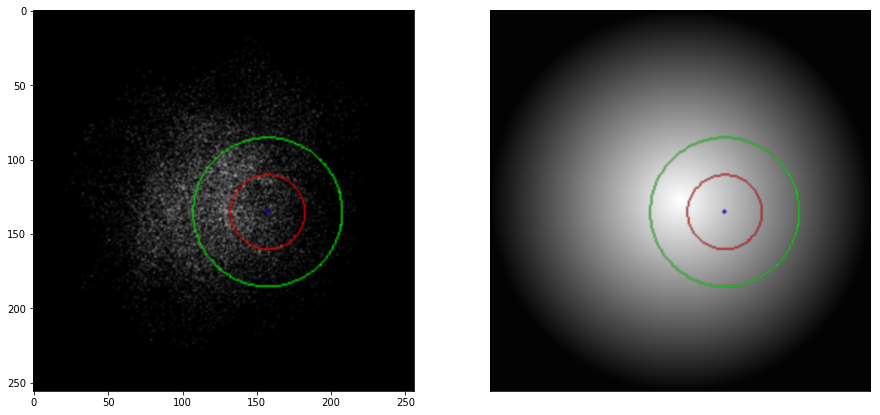

i: 20000
acceptance rate: 0.9493025348732563


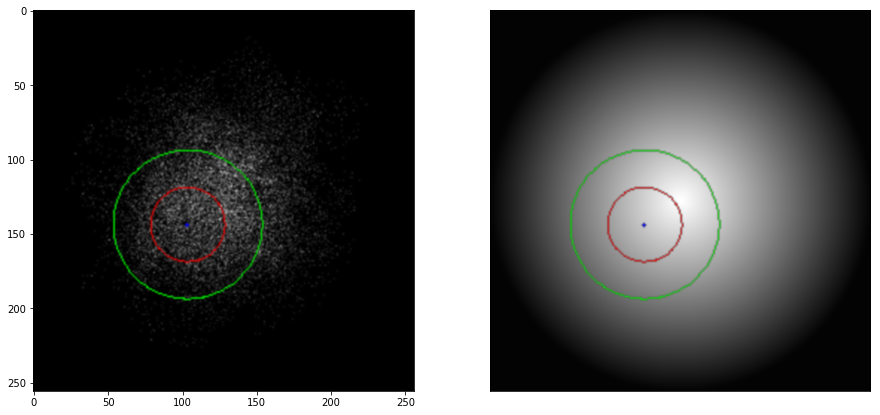

i: 21000
acceptance rate: 0.9489071948954811


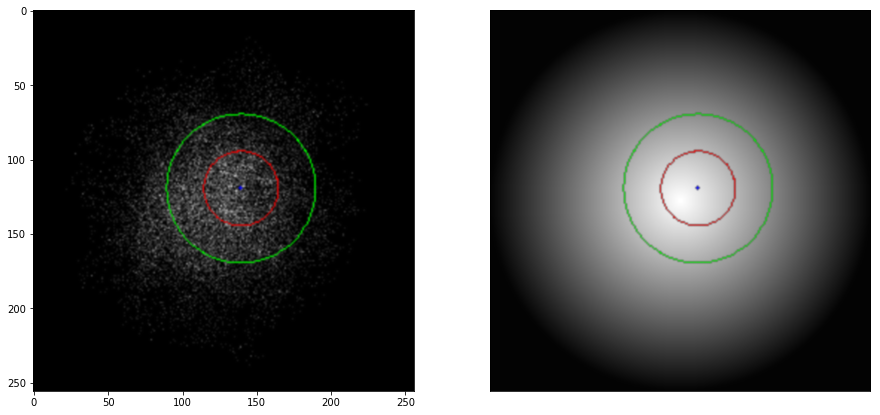

i: 22000
acceptance rate: 0.9490477705558839


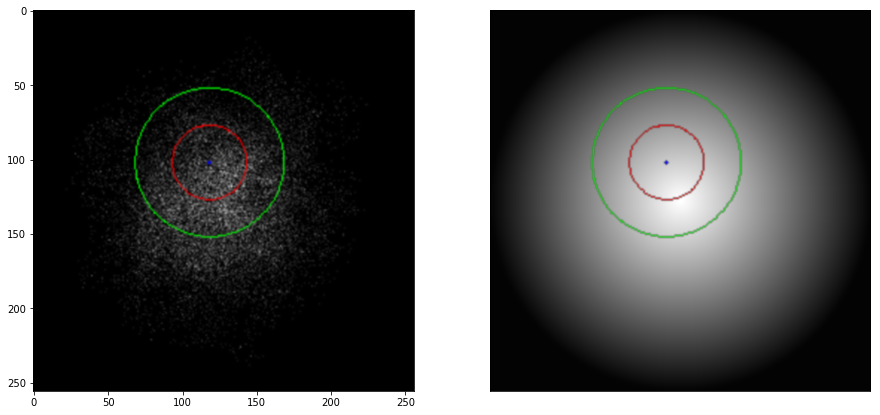

i: 23000
acceptance rate: 0.9492630755184557


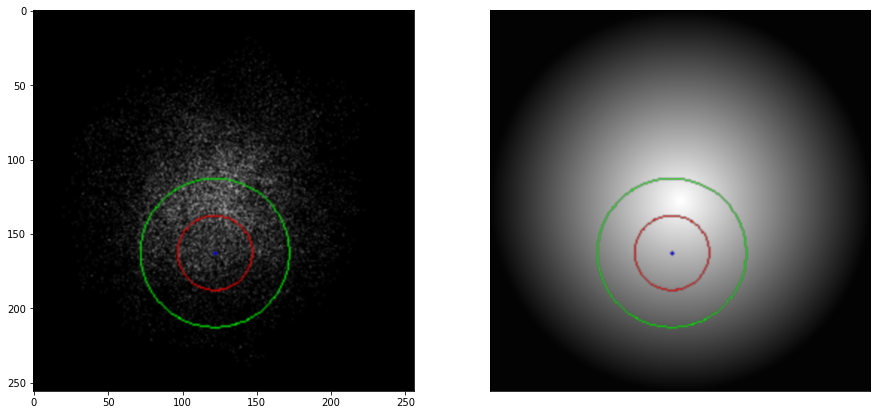

i: 24000
acceptance rate: 0.949377109287113


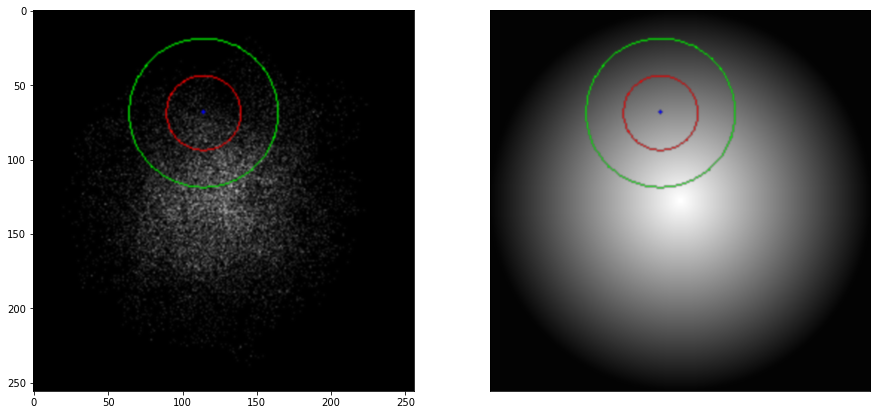

i: 25000
acceptance rate: 0.9499620015199391


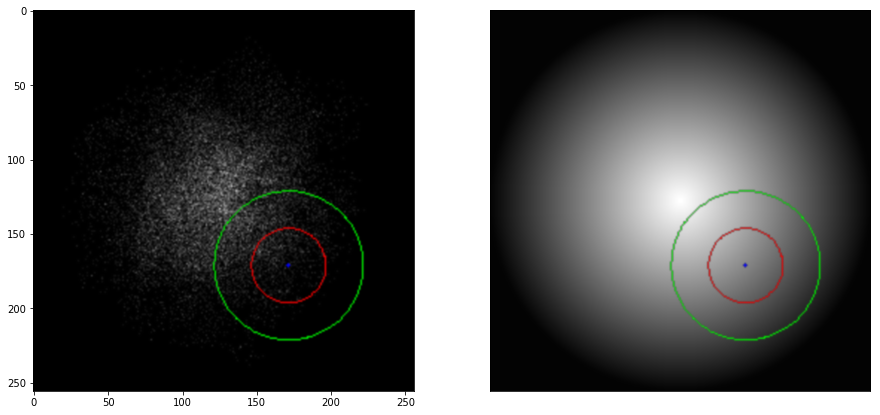

i: 26000
acceptance rate: 0.9501942232991039


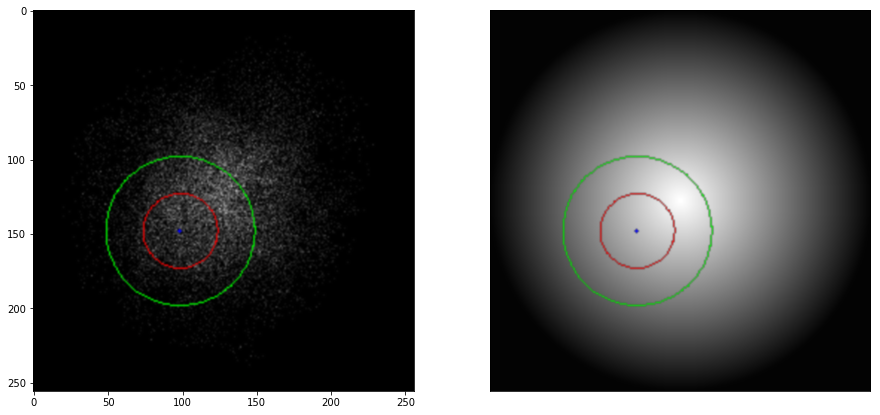

i: 27000
acceptance rate: 0.94963149512981


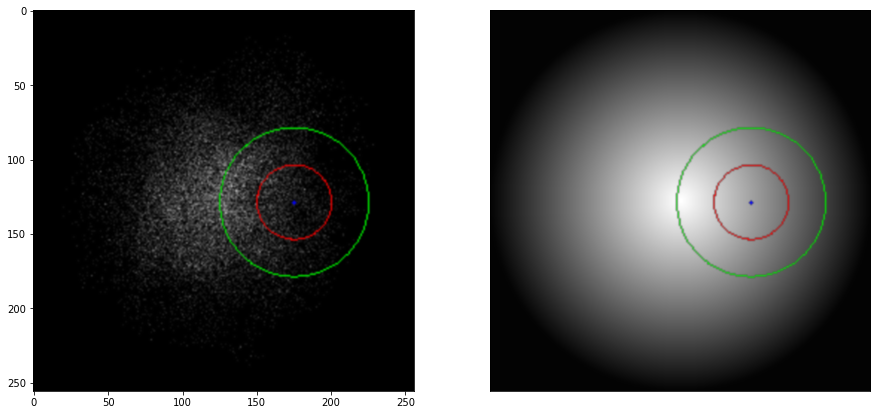

i: 28000
acceptance rate: 0.9495375165172673


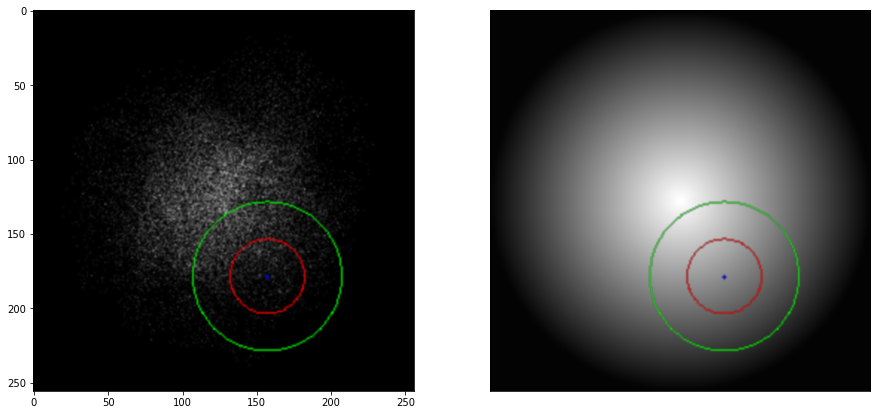

i: 29000
acceptance rate: 0.9494845005344643


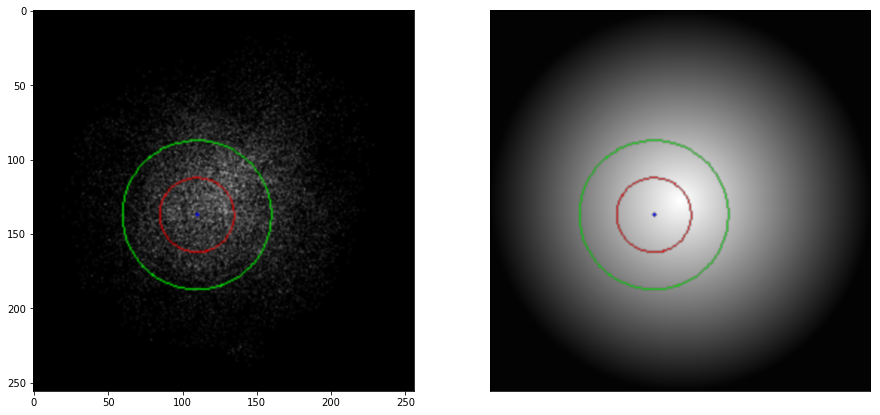

i: 30000
acceptance rate: 0.9497016766107796


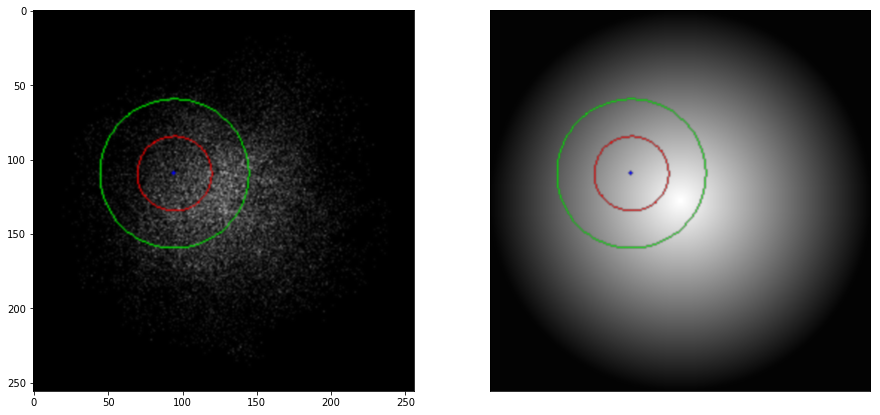

i: 31000
acceptance rate: 0.9496790426115287


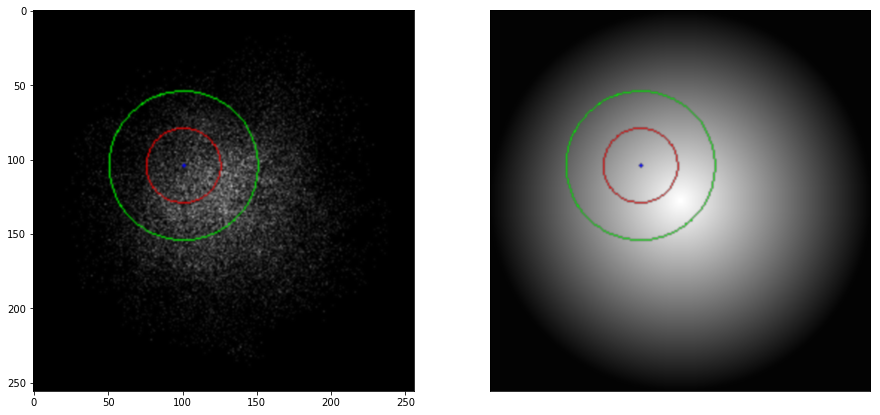

i: 32000
acceptance rate: 0.9498453173338334


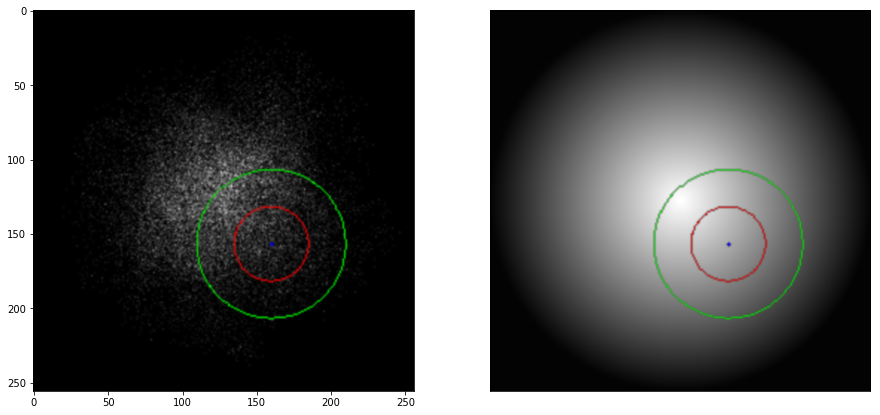

i: 33000
acceptance rate: 0.9499409108814885


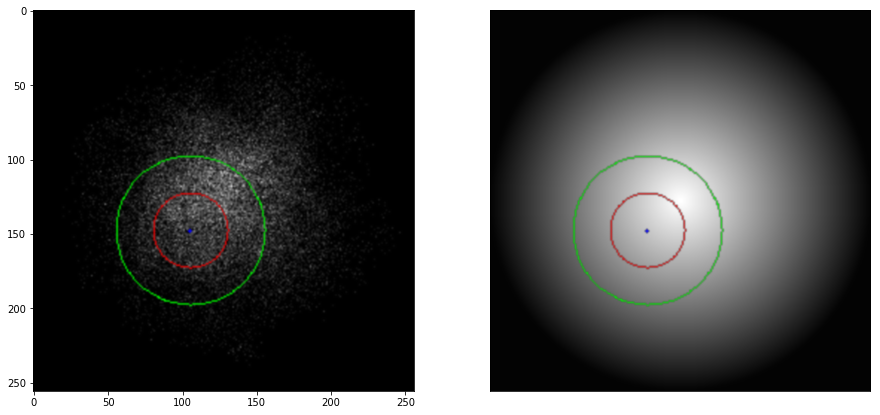

i: 34000
acceptance rate: 0.9500602923443429


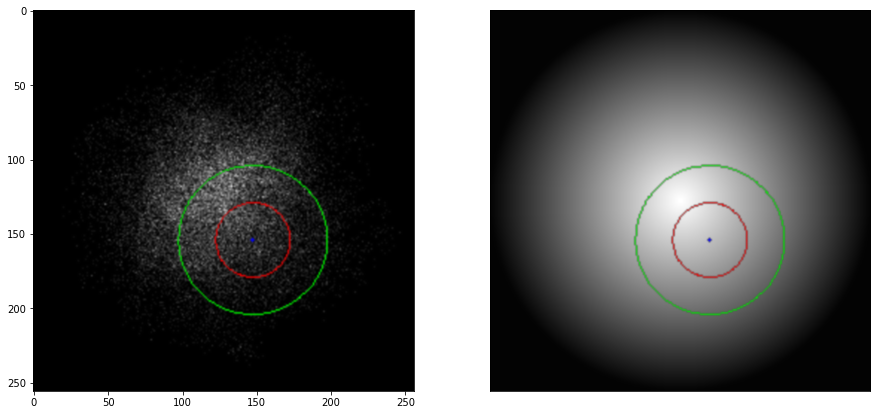

i: 35000
acceptance rate: 0.9498014342447358


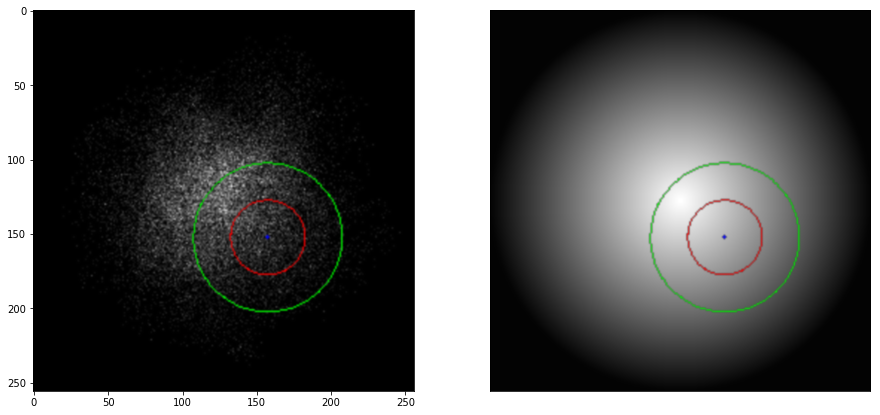

i: 36000
acceptance rate: 0.9501680508874754


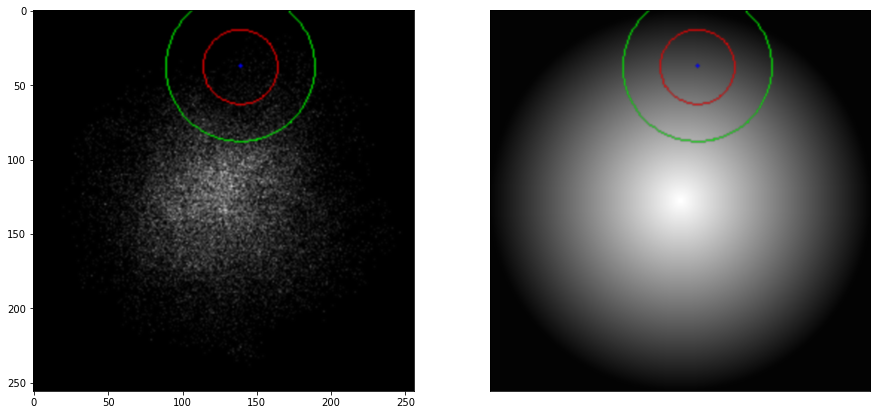

i: 37000
acceptance rate: 0.9506499824329072


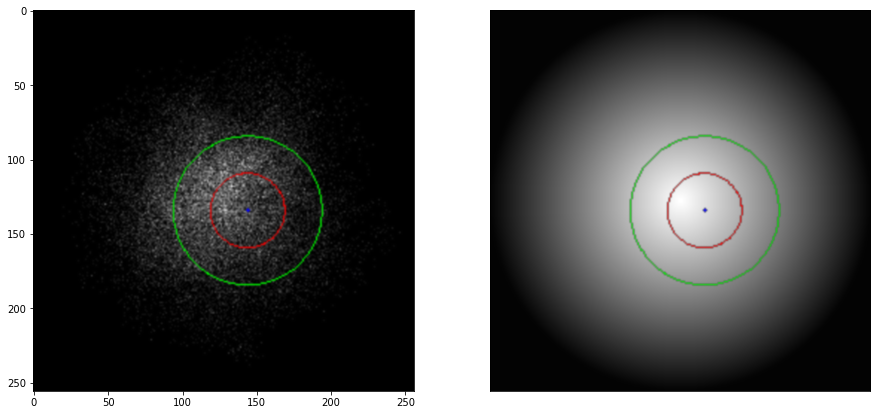

i: 38000
acceptance rate: 0.9506591931791268


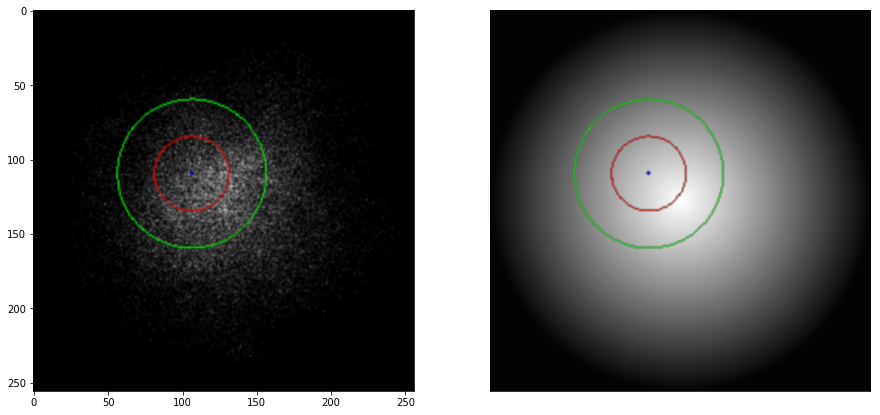

i: 39000
acceptance rate: 0.9499756416502141


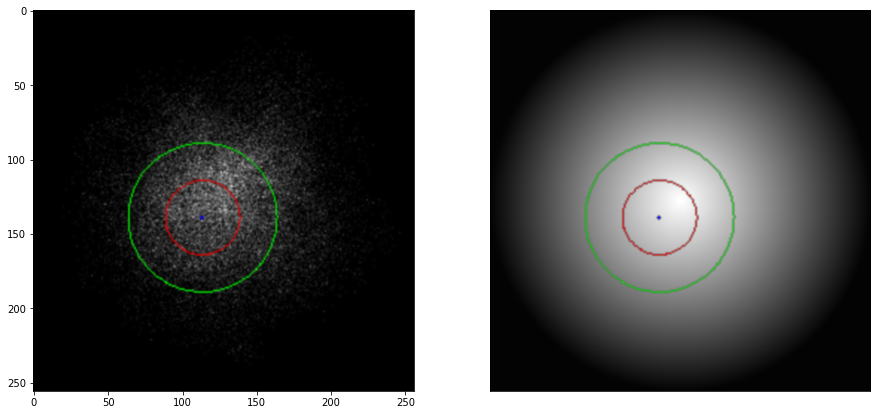

i: 40000
acceptance rate: 0.9502762430939227


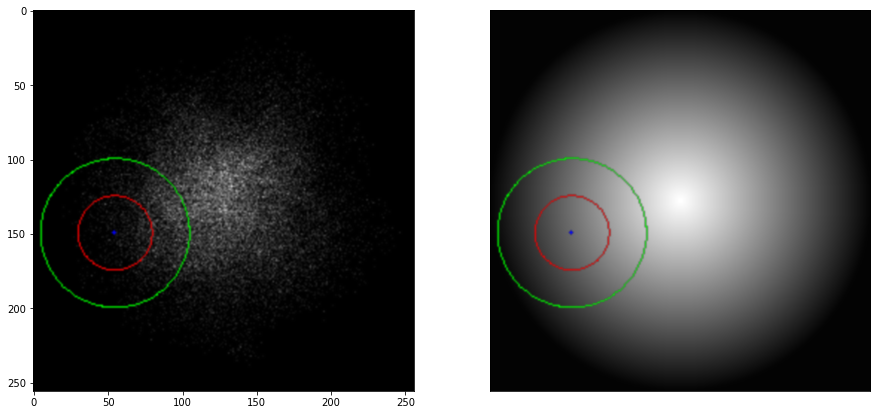

i: 41000
acceptance rate: 0.9500012194824516


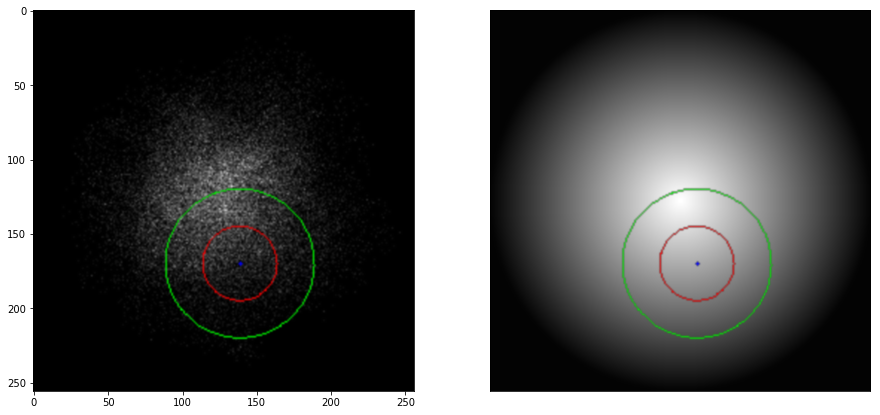

i: 42000
acceptance rate: 0.9498107187924097


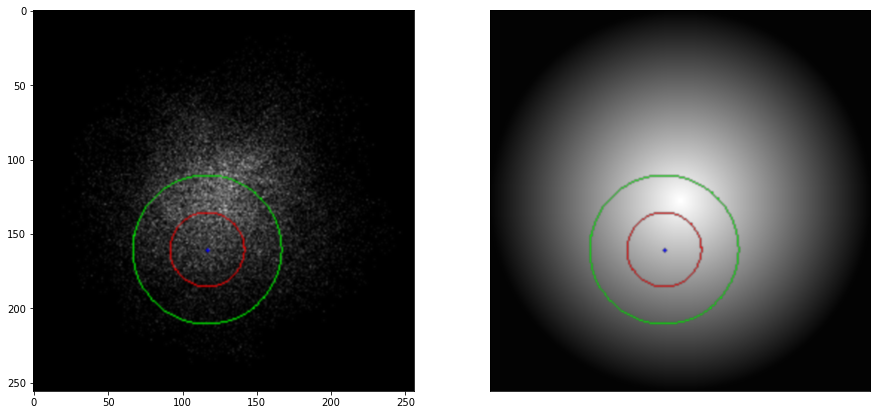

i: 43000
acceptance rate: 0.9497686100323248


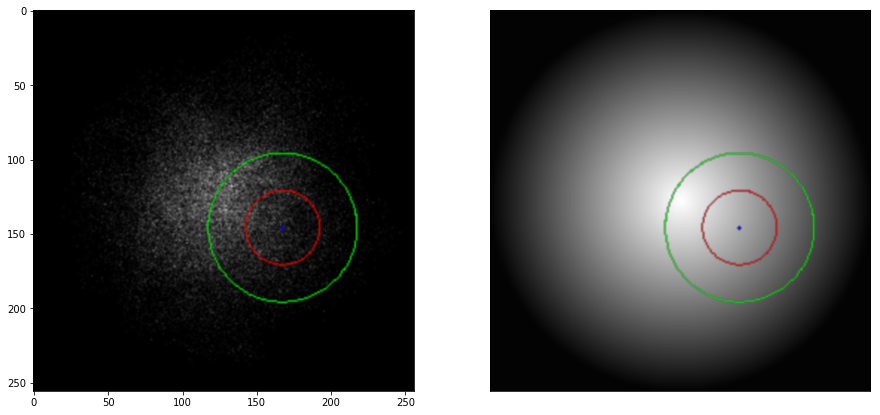

In [ ]:
makeHistogram(img_2)

In [ ]:
img_final = cv2.imread('MetropolisTest_Final.png',0)
print('img final max value: ' + repr(img_final.max()))
plt.imshow(img_final, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()

In [ ]:
img_error = np.absolute(img - img_final)/img.max()
print('img error max value: ' + repr(img_error.max()))
plt.imshow(img_error, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()